## nitesh.kumar@wsu.edu

In [1]:
import collections
import os
import sys
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as pl
import scipy.spatial as spatial
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm

from rdkit import Chem
import rdkit
from sklearn.base import TransformerMixin
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_predict, cross_validate, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

print(f"Python executable: {sys.executable}")
print(f"RDKit version: {rdkit.__version__}")


Python executable: /Users/nitesh.kumar/miniconda3/bin/python
RDKit version: 2023.03.2


In [3]:

def point_cloud(t):
    points =[]
    x = np.loadtxt(t,dtype=float,usecols=(1), skiprows=2)
    y = np.loadtxt(t,dtype=float,usecols=(2),skiprows=2)
    z = np.loadtxt(t,dtype=float,usecols=(3),skiprows=2)
    for i in range(len(x)):
        points.append([x[i],y[i],z[i]])
    return np.array(points)  

num_samples = 410
num_points = 22
num_dimensions = 3

X = np.zeros((num_samples, num_points, num_dimensions))

for i in range(num_samples):
    X[i,:,:] = point_cloud('/Volumes/NKMDISKAD/all_confs/frame_{}.xyz'.format(i))

print(X.shape)  


(410, 22, 3)


(410,)
[0.88560126]
(410, 1)
[0.02025527 0.02025527 0.06076582 0.10634018 0.10127636 0.14178691
 0.10634018 0.12659545 0.12153164 0.13672309 0.222808   0.23799945
 0.17216982 0.21774418 0.12153164 0.07595727 0.03038291 0.02025527
 0.01519145 0.02025527] [ 0.88560126  1.36725844  1.84891563  2.33057281  2.81222999  3.29388718
  3.77554436  4.25720155  4.73885873  5.22051591  5.7021731   6.18383028
  6.66548747  7.14714465  7.62880183  8.11045902  8.5921162   9.07377339
  9.55543057 10.03708775 10.51874494]


Text(0, 0.5, 'Probability')

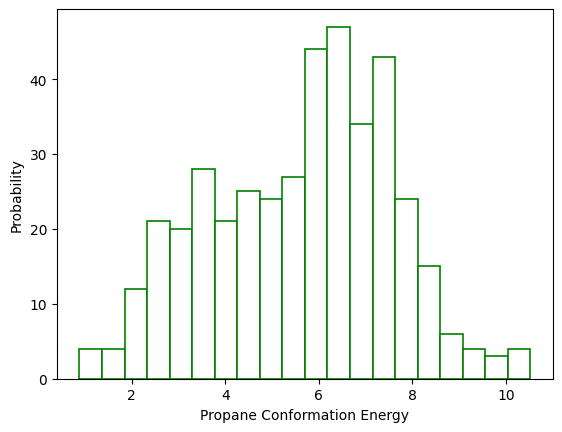

In [4]:

r = np.loadtxt("energy_vals.csv", delimiter='\t')
y3_ce = np.array(r).reshape(-1,1)
print(r.shape)

y3_ce = 627.503*(y3_ce + 37.70204410)
#y=pd.read_csv('conf_energy_n6.csv',usecols=[0])
print (y3_ce[0])
print(y3_ce.shape)


hist3, bin3 = np.histogram(y3_ce, bins=20, density=True)
print(hist3, bin3)

plt.hist(y3_ce,bins=20,density=False, edgecolor='green', linewidth=1.2,color="white")
#plt.xlim(0,100)
plt.xlabel('Energy')
plt.ylabel("Probability")

In [5]:
from sklearn.utils import shuffle

y = y3_ce
X, y = shuffle(X, y)
y = np.array(y.flatten())

In [6]:
print(X.shape)
print(y.shape)

(410, 22, 3)
(410,)


In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def test_learner(X, y, model):
    kf = KFold(n_splits=10, random_state=88, shuffle=True)
    rmse_errorlist = []
    mae_errorlist = []
    r2_list = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        rmse_error = np.sqrt(mean_squared_error(y_test, y_pred))
        mae_error = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        rmse_errorlist.append(rmse_error)
        mae_errorlist.append(mae_error)
        r2_list.append(r2)

    print('Final R2 score is {:.3f} ± {:.3f}'.format(np.mean(r2_list), np.std(r2_list)))
    print('Final RMSE error is {:.3f} ± {:.3f}'.format(np.mean(rmse_errorlist), np.std(rmse_errorlist)))
    print('Final MAE error is {:.3f} ± {:.3f}'.format(np.mean(mae_errorlist), np.std(mae_errorlist)))
        
    fig, axs = plt.subplots(1, 1, figsize=(5,5))
    axs.scatter(y_test, y_pred)
    axs.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], ls="--", c=".3")
    axs.set_xlim(np.min(y_test), np.max(y_test))
    axs.set_ylim(np.min(y_test), np.max(y_test))
    axs.set_xlabel('True values')
    axs.set_ylabel('Predicted values')
    axs.set_title('Predicted vs True')

## pointnet model 

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

class RMSD(tf.keras.metrics.Metric):
    def __init__(self, name="rmsd", **kwargs):
        super(RMSD, self).__init__(name=name, **kwargs)
        self.square_sum = self.add_weight(name="ss", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        error = tf.math.squared_difference(y_pred, y_true)
        self.square_sum.assign_add(tf.reduce_sum(error))
        self.count.assign_add(tf.cast(tf.size(y_true), dtype=tf.float32))

    def result(self):
        mean_square_error = tf.math.divide_no_nan(self.square_sum, self.count)
        return tf.math.sqrt(mean_square_error)

    def reset_states(self):
        self.square_sum.assign(0.)
        self.count.assign(0.)

def PointNet():
    input_points = layers.Input(shape=(None, 3)) # Assuming 3D point cloud data

    # First transform block
    x = layers.Conv1D(64, 1, activation='relu')(input_points)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(1024, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    global_feature = layers.GlobalMaxPooling1D()(x) 

    # Second transform block
    x = layers.Dense(512, activation='relu')(global_feature)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Output layer for regression
    output_class = layers.Dense(1)(x) 

    return tf.keras.Model(inputs=input_points, outputs=output_class, name='PointNet')

model = PointNet()


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error', RMSD(name='rmsd')]) 

2023-07-04 16:14:50.524153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 16:14:59.361216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


/Users/nitesh.kumar/miniconda3/lib/python3.8/site-packages/keras/engine/training.py:2416: UserWarning: Metric RMSD implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


2/2 [==============================] - 0s 9ms/step


/Users/nitesh.kumar/miniconda3/lib/python3.8/site-packages/keras/engine/training.py:2416: UserWarning: Metric RMSD implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


2/2 [==============================] - 0s 7ms/step


/Users/nitesh.kumar/miniconda3/lib/python3.8/site-packages/keras/engine/training.py:2416: UserWarning: Metric RMSD implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


2/2 [==============================] - 0s 7ms/step


/Users/nitesh.kumar/miniconda3/lib/python3.8/site-packages/keras/engine/training.py:2416: UserWarning: Metric RMSD implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


2/2 [==============================] - 0s 6ms/step


/Users/nitesh.kumar/miniconda3/lib/python3.8/site-packages/keras/engine/training.py:2416: UserWarning: Metric RMSD implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


2/2 [==============================] - 0s 6ms/step


/Users/nitesh.kumar/miniconda3/lib/python3.8/site-packages/keras/engine/training.py:2416: UserWarning: Metric RMSD implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


2/2 [==============================] - 0s 7ms/step


/Users/nitesh.kumar/miniconda3/lib/python3.8/site-packages/keras/engine/training.py:2416: UserWarning: Metric RMSD implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


2/2 [==============================] - 0s 6ms/step


/Users/nitesh.kumar/miniconda3/lib/python3.8/site-packages/keras/engine/training.py:2416: UserWarning: Metric RMSD implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


2/2 [==============================] - 0s 7ms/step


/Users/nitesh.kumar/miniconda3/lib/python3.8/site-packages/keras/engine/training.py:2416: UserWarning: Metric RMSD implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


2/2 [==============================] - 0s 6ms/step


/Users/nitesh.kumar/miniconda3/lib/python3.8/site-packages/keras/engine/training.py:2416: UserWarning: Metric RMSD implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


2/2 [==============================] - 0s 9ms/step
Final R2 score is 0.873 ± 0.130
Final RMSE error is 0.630 ± 0.256
Final MAE error is 0.507 ± 0.182


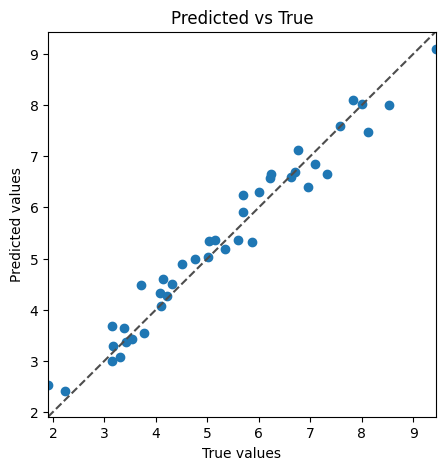

In [68]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def test_learner(X, y, model):
    kf = KFold(n_splits=10, random_state=88, shuffle=True)
    rmse_errorlist = []
    mae_errorlist = []
    r2_list = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=0)
        
        y_pred = model.predict(X_test)
        rmse_error = np.sqrt(mean_squared_error(y_test, y_pred))
        mae_error = mean_absolute_error(y_test, y_pred)
       
        r2 = r2_score(y_test, y_pred)
        
        rmse_errorlist.append(rmse_error)
        mae_errorlist.append(mae_error)
        r2_list.append(r2)

    print('Final R2 score is {:.3f} ± {:.3f}'.format(np.mean(r2_list), np.std(r2_list)))
    print('Final RMSE error is {:.3f} ± {:.3f}'.format(np.mean(rmse_errorlist), np.std(rmse_errorlist)))
    print('Final MAE error is {:.3f} ± {:.3f}'.format(np.mean(mae_errorlist), np.std(mae_errorlist)))
        
    fig, axs = plt.subplots(1, 1, figsize=(5,5))
    axs.scatter(y_test, y_pred)
    axs.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], ls="--", c=".3")
    axs.set_xlim(np.min(y_test), np.max(y_test))
    axs.set_ylim(np.min(y_test), np.max(y_test))
    axs.set_xlabel('True values')
    axs.set_ylabel('Predicted values')
    axs.set_title('Predicted vs True')
    
# Use the function
test_learner(X, y, model)


In [69]:
import joblib
joblib.dump(model, 'pointnet.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......batch_normalization_3
.........vars
............0
............1
............2
............3
......batch_normalization_4
.........vars
............0
............1
............2
............3
......conv1d
.........vars
............0
............1
......conv1d_1
.........vars
............0
............1
......conv1d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......global_max_pooling1d
.........vars
......input_layer
.........vars
...metrics
......mean
......

['pointnet.pkl']

In [70]:
model_loaded = joblib.load('pointnet.pkl')
new_data = X[0:10] 
prediction = model_loaded.predict(new_data)
print(prediction)  



Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-07-04 00:36:48         8083
metadata.json                                  2023-07-04 00:36:48           64
variables.h5                                   2023-07-04 00:36:48      9695664
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......batch_normalization_3
.........vars
............0
............1
............2
............3
......batch_normalization_4
.........vars
............0
............1
............2
............3
......conv1d
.........vars
............0
............1
......conv1d_1
.........vars
...

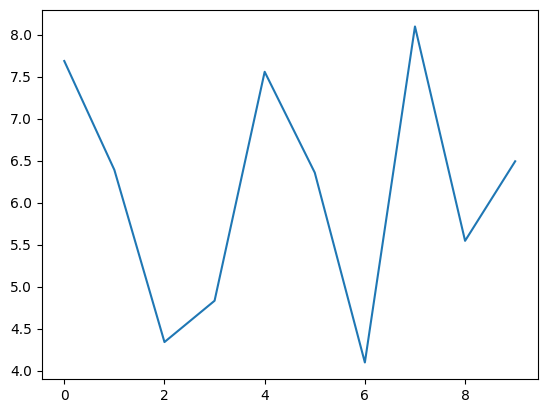

In [71]:
plt.plot(prediction)

In [72]:
print(prediction)

[[7.6863194]
 [6.389866 ]
 [4.340436 ]
 [4.832293 ]
 [7.5578327]
 [6.3573103]
 [4.097428 ]
 [8.097225 ]
 [5.5456295]
 [6.4925346]]
